# Assignment 1 - Action Score Modelling

Now that we have explored (and compared with other datasets) the textual data for the DAX companies, we want to use the textual information in order to predict the mean action score for each document. We will classif the action score in three classes to simplify the interpretation:
1. `low`: below 0.1 which represents about 50% of the dataset
2. `medium`: between 0.1 and 0.9 which represents about 30% of the dataset
3. `high`: above 0.9 which represents the remaining 20%.
The reason for this choice was the distribution of the scores in our dataset that made these cut-offs quite natural (cf. histogram and cumulative distribution).

To predict these three classes we will use the documents' embeddings:
- `Bag of Words`: embedding based on the frequency of the tokens in the document
- `TF-IDF`: embedding based on the frequency of the tokens in the document and the frequency of the tokens in the corpus
- `Word2Vec`: embedding based on a pretrained word2vec model to summarise the meaning of the document
For each of these embeddings, we will cross-validate (strategy: stratified 3-fold) the following classifiers:
- `Logistic Regression` as a baseline
- `Decision Tree` to explore non-linear relationships
- `Random Forest` to explore non-linear relationships and get more robust results

To do so, we developed a set of functions to be used in the following pipeline:
1. `Data preparation`: we stack the embeddings and retrieve the action scores (X and y)
2. `Model evaluation`: we cross-validate the models and fetch the results (accuracy, precision, recall, f1-score)
3. `Logs`: we save the results in an excel file with a name and a timestamp to keep track of the different runs

---
---

*To improve on this notebook, we could try to expend the BOW and TD-IDF vocabulary sizes and add a neural network to the classifiers. We could also try other Word2Vec embeddings or tokenizers. Finally we could also use and fine-tune a transformer to be able to capture context (attention) and order (positioning) in our initial text.*

## 1. Data preparation

We will load the pickles containing the tokens and embeddings for each document that we created in the previous notebook. We will then split the target variable (mean action score) into three classes based on the distribution.

In [1]:
import pandas as pd
from collections import Counter
import tqdm
tqdm.tqdm.pandas()
import matplotlib.pyplot as plt
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_pickle("https://media.githubusercontent.com/media/MathieuDemarets/vlerick-mai-nlp-2023/Local/DATA/esg_documents_for_dax_companies_score_tok_emb.pkl")
df = pd.read_pickle("DATA/esg_documents_for_dax_companies_score_tok_emb.pkl")

df.head()

c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url,mean_action_score,n_chunks,n_estimated_actions,size_char,tokens,embedding
0,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,0.883412,25.0,22.0,56786,"[sustainability, highlight, report, care, skin...","[-0.30426386, 0.5005032, 0.44396603, 0.0309295..."
1,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN,0.663768,263.0,173.0,619607,"[corporate, responsibility, report, 2021, 2, c...","[-0.355663, 0.29826087, 0.4589993, -0.21578589..."
2,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN,0.429047,193.0,79.0,444517,"[se, sustainability, report, 2021, sustainable...","[-0.16401269, 0.27424163, 0.2612646, -0.127146..."
3,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN,0.679299,210.0,142.0,543061,"[sustainability, report, 2021, table, content,...","[-0.17004943, 0.053052265, 0.28615195, -0.2306..."
4,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN,0.682892,102.0,68.0,256566,"[idea, concept, sustainable, future, idea, con...","[-0.22982949, 0.39467514, 0.258867, -0.1323035..."


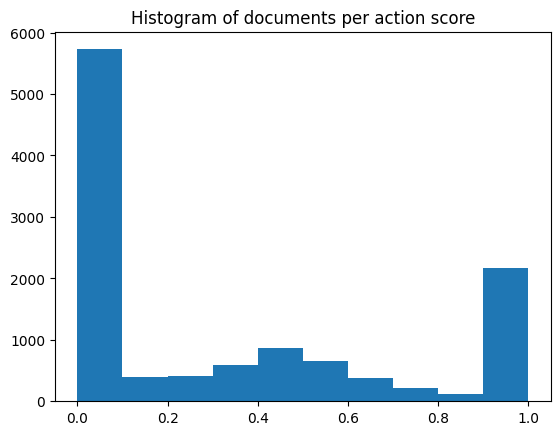

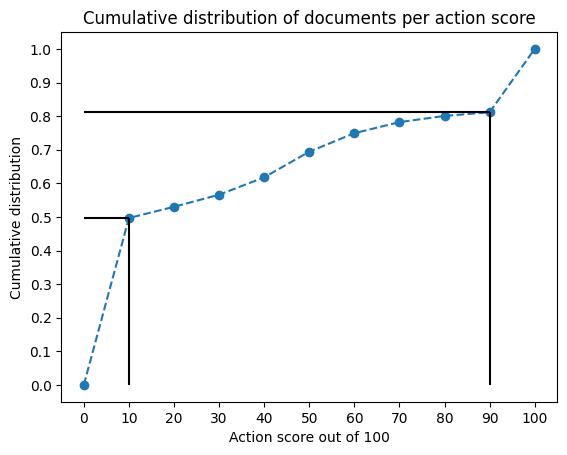

In [2]:
# Histogram
plt.hist(df['mean_action_score'], bins=10)
plt.title("Histogram of documents per action score")
plt.show()

# Cumulative distribution
x = list(range(0,101,10))
y = [sum(df["mean_action_score"]<=(threshold/100))/df.shape[0] for threshold in x]
plt.plot(x,y,"o--")
plt.vlines([10,90], 0, [sum(df["mean_action_score"]<=(threshold/100))/df.shape[0] for threshold in [10,90]], color='black')
plt.hlines([sum(df["mean_action_score"]<=(threshold/100))/df.shape[0] for threshold in [10,90]], 0, [10,90], color="black")
plt.title("Cumulative distribution of documents per action score")
plt.xticks(list(range(0,101,10)))
plt.xlabel("Action score out of 100")
plt.yticks([i/100 for i in list(range(0,101,10))])
plt.ylabel("Cumulative distribution")
plt.show()

In [3]:
def categorize_action(df, from_col, to_col):
    cat = lambda x: "low" if x < 0.1 else "medium" if x < 0.9 else "high"
    df[to_col] = df[from_col].progress_apply(cat)

categorize_action(df,"mean_action_score","action_category")

100%|██████████| 11531/11531 [00:00<00:00, 1050945.66it/s]


In [4]:
# We get relatively balanced classes (low: 50%, medium: 30%, high: 20%)
print(df.action_category.value_counts())
print(round(df.action_category.value_counts(normalize=True)*100,2))

action_category
low       5728
medium    3630
high      2173
Name: count, dtype: int64
action_category
low       49.67
medium    31.48
high      18.84
Name: proportion, dtype: float64


## 2. Bag of Words (BoW)

This first approach to text embedding aims to classify the action category based on the frequency of words in the document. We will:
- Use a `Counter` to count the number of occurences of each word in the corpus
- Define a `Vocabulary` based on the most frequent words
- Define a `Bag of Words` representation for each document
- Train our `classifiers` on the Bag of Words representation

### 2.1. Data preparation

In [5]:
def vocabBOW(df, vocab_size=1000, verbose=False):
    """Creates a vocabulary of the most common words in the corpus and maps each word to an integer

    Parameters
    ----------
    df : DataFrame
        Corpus of documents
    vocab_size : int, optional
        Size of the vocabulary, by default 1000
    verbose : bool, optional
        Display details, by default False

    Returns
    -------
    tokenMap : dict
        Word to integer mapping
    tokenMapInverse : dict
        Integer to word mapping
    tokenFreq : Counter
        Word frequencies
    """
    tokenFreq = Counter()
    df['tokens'].progress_apply(lambda x: tokenFreq.update(x))

    if verbose:
        print(f"Total number of words: {sum(tokenFreq.values())}")
        print(f"Number of unique words: {len(tokenFreq)}")
        print(f"Most common words: {tokenFreq.most_common(5)}")
        print(f"Least common words: {tokenFreq.most_common()[:-5:-1]}")
    
    tokenMap = {k: i+1 for i, (k, _) in enumerate(tokenFreq.most_common(vocab_size-1))} # -1 to account for the <oov> token
    tokenMap["<oov>"]=0 # Out of vocabulary token to account for words not in the vocabulary
    tokenMapInverse = {v: k for k,v in tokenMap.items()}

    return tokenMap, tokenMapInverse, tokenFreq

In [35]:
tokenMap, tokenMapInverse, tokenFreq = vocabBOW(df, vocab_size=1000, verbose=True)

  0%|          | 0/11531 [00:00<?, ?it/s]

100%|██████████| 11531/11531 [00:01<00:00, 6378.71it/s]

Total number of words: 9755261
Number of unique words: 68953
Most common words: [('company', 52851), ('year', 52258), ('market', 51242), ('s', 47014), ('report', 44278)]
Least common words: [('lowercase', 1), ('mistimed', 1), ('ubiquitousness', 1), ('shaheen', 1)]


When looking at the least frequent words, we see words such as 'algun', 'arroz', and 'usados'. It therefore seems that some documents are in Spanish. In the future, these documents should be removed from the dataset because the model will not be able to learn from them (too small amount to have a multi-language vocabulary) and they will only add noise to the dataset.

In [7]:
tokenFreq.most_common(len(tokenFreq))[-100:][:10]

[('millennials', 1),
 ('déficit', 1),
 ('informações', 1),
 ('nutricional', 1),
 ('algun', 1),
 ('fios', 1),
 ('arroz', 1),
 ('juntas', 1),
 ('falar', 1),
 ('usados', 1)]

In [8]:
def embedBOW(example, vocab_size=1000, tokenMap=tokenMap):
    """Embeds a document as a Bag of Words vector

    Parameters
    ----------
    example : list
        List of tokens
    vocab_size : int, optional
        Size of the vocabulary, by default 1000
    tokenMap : dict, optional
        Word to integer mapping, by default tokenMap
    
    Returns
    -------
    embedding : np.array
        Bag of Words vector
    """
    embedding = np.zeros(vocab_size)
    for token in example:
        try:
            tokenIndex = tokenMap[token] # get index of token in vocabulary
        except KeyError: # Out of vocabulary
            tokenIndex = 0
        embedding[tokenIndex] = embedding[tokenIndex] + 1 # increment count of token
    return embedding

df["embeddedBOW"] = df['tokens'].progress_apply(embedBOW)


  0%|          | 0/11531 [00:00<?, ?it/s]

100%|██████████| 11531/11531 [00:07<00:00, 1577.44it/s]


In [54]:
def data_prep(df, embed_col="embeddedBOW", verbose=False):
    """Prepares data for BOW models

    Parameters
    ----------
    df : DataFrame
        Corpus of documents
    embed_col : str, optional
        Name of the column containing the embeddings, by default "embeddedBOW"
    verbose : bool, optional
        Display the details, by default False

    Returns
    -------
    X : DataFrame
        Set of predictors
    y : Series
        Target variable
    """
    if verbose:
        print(">>> Preparing data for BOW model")
    X = pd.DataFrame(np.stack(df[embed_col]))
    y = df["action_category"]
    X.columns = [tokenMapInverse[i] for i in X.columns]
    if verbose:
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
    return X, y

# X, y = data_prep(df, embed=False, verbose=True) # Test successful

### 2.2. Keeping the logs

We start by making sure that we can keep track of all our experiments. We will create a function that will save the results of our experiments in an excel file.

In [9]:
import datetime
# logs = pd.DataFrame(columns=["name", "accuracy", "precision", "recall", "f1 score", "time"])
# logs.to_excel("DATA/logs.xlsx", index=False)

def log_experiment(stats, name=None, filename="DATA/logs.xlsx", verbose=False):
    """Log experiment results in an Excel file.

    Parameters
    ----------
    name : str
        Name of the experiment.
    stats : dict
        Dictionary of statistics to log.
    filename : str, optional
        Name of the Excel file, by default "DATA/logs.xlsx".
    """
    if verbose:
        print(">>> Logging experiment...")
    stats = stats.loc[:,["accuracy", "precision", "recall", "f1 score"]]
    if name is None:
        stats["name"] = input("Name of the experiment: ")
    else:
        stats["name"] = name
    stats["time"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    stats = stats[["name", "accuracy", "precision", "recall", "f1 score", "time"]]
    logs = pd.read_excel(filename)
    logs = pd.concat([logs,stats])
    logs.sort_values(by="f1 score", ascending=False, inplace=True)
    logs.to_excel(filename, index=False)
    if verbose:
        print(">>> Experiment logged.")

# stats = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1 score"])
# stats.loc[len(stats)] = [0.5, 0.5, 0.5, 0.5]
# stats
# log_experiment(stats) # Test successful

### 2.3. Model evaluation

We set up a function to cross-validate our models and retrieve the results. We will use the following metrics:
- `accuracy`: the proportion of correct predictions
- `precision`: the proportion of correct positive predictions (TP / (TP + FP))
- `recall`: the proportion of actual positives that were correctly identified (TP / (TP + FN))
- `f1-score`: the harmonic mean of precision and recall which gives us a global view of the model's performance

We namely chose to use the `f1-score` to rank all our runs because it gives us a good balance between precision and recall.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

def model_evaluation(model, X, y, cv=3, verbose=False, random_state=42):
    """Evaluate a model using stratified cross-validation

    Parameters
    ----------
    model : classifier object
        Model to evaluate
    X : DataFrame
        Set of predictors
    y : Series
        Target variable
    cv : int, optional
        Number of folds, by default 3
    verbose : bool, optional
        Display details, by default False
    random_state : int, optional
        Seed to fix, by default 42

    Returns
    -------
    stats : DataFrame
        Results of the evaluation
    """
    if verbose:
        print(">>> Model evaluation:")
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state) # 3-fold cross-validation
    precision_scoring = make_scorer(precision_score, average='macro')
    recall_scoring = make_scorer(recall_score, average='macro')
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_validate(
        model, X, y, cv=skf, scoring={
            'accuracy': 'accuracy',
            'precision': precision_scoring,
            'recall': recall_scoring,
            'f1 score': f1_scorer,
        })
    return_dict = {}
    for score, value in scores.items():
        if score != 'fit_time' and score != 'score_time':
            if verbose:
                print(f"{score}: {value.mean():.2%} +/- {value.std():.4%}")
            return_dict[score.split('_')[1]] = value.mean()
    stats = pd.DataFrame(return_dict, index=[0])
    return stats

# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(random_state=42)
# X, y = data_prep_bow(df, embed=False, verbose=True)
# stats = model_evaluation(model, X, y, cv=3, verbose=True)
# stats

## 3. Full pipeline

Now that we have all the components of our pipeline, we can create the backbone of our experiment. We will reuse the same pipeline to evaluate the three embeddings (BoW, TF-IDF, Word2Vec) and the three classifiers (Logistic Regression, Decision Tree, Random Forest) combinations. We also create a helper function to initialise the different models so that we can easily reuse them.

In [55]:
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

seed=123
def get_initial_models(random_state=123):
    """Helper function to create the initial models for the project.

    Parameters
    ----------
    random_state : int, optional
        Seed for reproductibility, by default 123

    Returns
    -------
    dict
        Dictionary of initial models
    """
    return {
        "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(random_state=seed, max_iter=1000)), # Baseline model
        "Decision Tree": DecisionTreeClassifier(random_state=seed), # Add non-linearity with decision tree
        "Random Forest": RandomForestClassifier(random_state=seed), # Make the decision tree more robust with random forest (ensemble of decision trees)
    }

def pipeline_classification(df, model, name=None, embed_col="embeddedBOW", verbose=True):
    """Pipeline to train and evaluate a classification model

    Parameters
    ----------
    df : DataFrame
        Corpus of documents
    model : classifier object
        Model to train and evaluate
    name : str, optional
        Name of the experiment for the logs, by default None
    embed_col : str, optional
        Name of the column with the name embeddings, by default "embeddedBOW"
    verbose : bool, optional
        Display details, by default True
    """
    X,y = data_prep(df, embed_col=embed_col, verbose=verbose)
    stats = model_evaluation(model, X, y, cv=3, verbose=verbose)
    log_experiment(stats, name=name, verbose=verbose)

### 3.1. Bag of Words models evaluation

In [56]:
models = get_initial_models()
for name, model in models.items():
    print(f"START Training {name}...")
    pipeline_classification(df, model, name="BOW "+name, verbose=True)
    print(f"DONE {name} trained.")

pd.read_excel("DATA/logs.xlsx")

START Training Logistic Regression...
>>> Preparing data for BOW model
X shape: (11531, 1000)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 70.25% +/- 0.1423%
test_precision: 67.14% +/- 0.3787%
test_recall: 67.15% +/- 0.3030%
test_f1 score: 67.08% +/- 0.3433%
>>> Logging experiment...
>>> Experiment logged.
DONE Logistic Regression trained.
START Training Decision Tree...
>>> Preparing data for BOW model
X shape: (11531, 1000)
y shape: (11531,)
>>> Model evaluation:


C:\Users\User\AppData\Local\Temp\ipykernel_17672\3853218247.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  logs = pd.concat([logs,stats])


test_accuracy: 59.20% +/- 0.3817%
test_precision: 55.58% +/- 0.4398%
test_recall: 55.32% +/- 0.1744%
test_f1 score: 55.42% +/- 0.2707%
>>> Logging experiment...
>>> Experiment logged.
DONE Decision Tree trained.
START Training Random Forest...
>>> Preparing data for BOW model
X shape: (11531, 1000)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 71.79% +/- 0.3885%
test_precision: 70.95% +/- 0.1608%
test_recall: 65.64% +/- 0.6456%
test_f1 score: 67.31% +/- 0.5619%
>>> Logging experiment...
>>> Experiment logged.
DONE Random Forest trained.


,name,accuracy,precision,recall,f1 score,time
0,BOW Random Forest,0.717891,0.709523,0.656441,0.673146,2024-01-18 13:12
1,BOW Logistic Regression,0.702541,0.671361,0.671515,0.670760,2024-01-18 13:11
2,BOW Decision Tree,0.591969,0.555765,0.553179,0.554248,2024-01-18 13:11


## 4. TF-IDF embedding

The BOW approach already gave us good results. However, we now want to see if we could do better by giving different weights to the words in the vocabulary. To do so, we will use the TF-IDF embedding which gives more weight to the words that occur in less documents.

In [57]:
def vocabTFIDF(df, vocab_size=1000, verbose=False):
    """Creates a vocabulary of the words that appear in the most documents and maps each word to an integer

    Parameters
    ----------
    df : DataFrame
        Corpus of documents
    vocab_size : int, optional
        Size of the vocabulary to create, by default 1000
    verbose : bool, optional
        Display details, by default False

    Returns
    -------
    tokenMap : dict
        Word to integer mapping
    tokenMapInverse : dict
        Integer to word mapping
    Doc_Tok_freq : Counter
        Number of documents in which each token appears
    """
    Doc_Tok_freq = Counter()
    tfidf_update = lambda x: Doc_Tok_freq.update(set(x))
    df['tokens'].progress_apply(tfidf_update) # Count number of documents in which each token appears

    if verbose:
        print(f"Number of unique words: {len(Doc_Tok_freq)}")
        print(f"Words that appear in most documents: {Doc_Tok_freq.most_common(5)}")
        print(f"Least common words: {Doc_Tok_freq.most_common()[:-5:-1]}")
    
    tokenMap = {k: i for i, (k, _) in enumerate(Doc_Tok_freq.most_common(vocab_size))} # We don't use the <oov> token here because we won't use it in the embedding
    tokenMapInverse = {v: k for k,v in tokenMap.items()}
    return tokenMap, tokenMapInverse, Doc_Tok_freq

tokenMapTFIDF, tokenMapInverseTFIDF, Doc_Tok_freq = vocabTFIDF(df, vocab_size=1000, verbose=True)

100%|██████████| 11531/11531 [00:02<00:00, 5247.04it/s]

Number of unique words: 68953
Words that appear in most documents: [('new', 7681), ('company', 7660), ('year', 7612), ('s', 7039), ('include', 6598)]
Least common words: [('naysaye', 1), ('overbuild', 1), ('lowercase', 1), ('300x', 1)]


In [58]:
def embedTFIDF(example, vocab_size=1000, tokenMap=tokenMapTFIDF, tokenMapInverse=tokenMapInverseTFIDF, Doc_Tok_freq=Doc_Tok_freq, df=df):
    """Embeds a document as a TF-IDF vector

    Parameters
    ----------
    example : list
        List of tokens
    vocab_size : int, optional
        Size of the vocabulary, by default 1000
    tokenMap : dict, optional
        Word to integer mapping, by default tokenMapTFIDF
    tokenMapInverse : dict, optional
        Integer to word mapping, by default tokenMapInverseTFIDF
    Doc_Tok_freq : dict, optional
        Word to number of documents mapping, by default Doc_Tok_freq
    df : DataFrame, optional
        Corpus of documents, by default df

    Returns
    -------
    embedding : np.array
        TF-IDF vector
    """
    embedding = np.zeros(vocab_size)
    term_freq = Counter(example)
    for token in term_freq.keys():
        try:
            tokenIndex = tokenMap[token] # get index of token in vocabulary
        except KeyError: # Out of vocabulary
            tokenIndex = 0
        if tokenIndex != 0: # If the token is oov, we don't include it in the embedding because we would divide by 0
            idf = np.log(df.shape[0]/Doc_Tok_freq[tokenMapInverse[tokenIndex]])
            embedding[tokenIndex] = term_freq[token]*idf
    return embedding

df["embeddedTFIDF"] = df['tokens'].progress_apply(embedTFIDF)

  0%|          | 0/11531 [00:00<?, ?it/s]

100%|██████████| 11531/11531 [00:08<00:00, 1335.13it/s]


### 4.1. Model evaluation with TF-IDF

In [59]:
models = get_initial_models()
for name, model in models.items():
    print(f"START Training {name}...")
    pipeline_classification(df, model, name="TFIDF "+name, embed_col="embeddedTFIDF", verbose=True)
    print(f"DONE {name} trained.")

pd.read_excel("DATA/logs.xlsx")

START Training Logistic Regression...
>>> Preparing data for BOW model
X shape: (11531, 1000)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 69.32% +/- 0.3368%
test_precision: 66.01% +/- 0.3459%
test_recall: 66.20% +/- 0.2699%
test_f1 score: 66.06% +/- 0.2858%
>>> Logging experiment...
>>> Experiment logged.
DONE Logistic Regression trained.
START Training Decision Tree...
>>> Preparing data for BOW model
X shape: (11531, 1000)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 56.66% +/- 0.7769%
test_precision: 52.46% +/- 0.9609%
test_recall: 52.73% +/- 1.0424%
test_f1 score: 52.58% +/- 0.9972%
>>> Logging experiment...
>>> Experiment logged.
DONE Decision Tree trained.
START Training Random Forest...
>>> Preparing data for BOW model
X shape: (11531, 1000)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 71.49% +/- 0.2378%
test_precision: 70.43% +/- 0.4047%
test_recall: 65.14% +/- 0.3693%
test_f1 score: 66.78% +/- 0.3038%
>>> Logging experiment...
>>> Experiment logg

,name,accuracy,precision,recall,f1 score,time
0,BOW Random Forest,0.717891,0.709523,0.656441,0.673146,2024-01-18 13:12
1,BOW Logistic Regression,0.702541,0.671361,0.671515,0.670760,2024-01-18 13:11
2,TFIDF Random Forest,0.714856,0.704337,0.651406,0.667785,2024-01-18 13:14
3,TFIDF Logistic Regression,0.693175,0.660128,0.662045,0.660568,2024-01-18 13:14
4,BOW Decision Tree,0.591969,0.555765,0.553179,0.554248,2024-01-18 13:11
5,TFIDF Decision Tree,0.566560,0.524608,0.527324,0.525799,2024-01-18 13:14


## 5. Word2Vec embedding

The TF-IDF embedding did not improve the performance of the models. This might be because a vocabulary of 1000 words is too small and thus the "rare" words are simply excluded. However, the dataset is small and we can't afford to make the model more complex by increasing the vocabulary size. Instead, we will try to use a pre-trained embedding model to represent all the tokens and not only the 1000 most frequent ones. We already created the embedding model in the previous notebook, so we will simply use it here.

In [61]:
models = get_initial_models()
for name, model in models.items():
    print(f"START Training {name}...")
    pipeline_classification(df, model, name="W2V "+name, embed_col="embedding", verbose=True)
    print(f"DONE {name} trained.")

pd.read_excel("DATA/logs.xlsx")

START Training Logistic Regression...
>>> Preparing data for BOW model
X shape: (11531, 384)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 70.18% +/- 0.3775%
test_precision: 67.50% +/- 0.4587%
test_recall: 66.52% +/- 0.5483%
test_f1 score: 66.95% +/- 0.5137%
>>> Logging experiment...
>>> Experiment logged.
DONE Logistic Regression trained.
START Training Decision Tree...
>>> Preparing data for BOW model
X shape: (11531, 384)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 54.28% +/- 0.5984%
test_precision: 50.84% +/- 0.6327%
test_recall: 50.98% +/- 0.6355%
test_f1 score: 50.90% +/- 0.6271%
>>> Logging experiment...
>>> Experiment logged.
DONE Decision Tree trained.
START Training Random Forest...
>>> Preparing data for BOW model
X shape: (11531, 384)
y shape: (11531,)
>>> Model evaluation:
test_accuracy: 68.52% +/- 0.4174%
test_precision: 68.08% +/- 0.5900%
test_recall: 61.64% +/- 0.5821%
test_f1 score: 63.39% +/- 0.6258%
>>> Logging experiment...
>>> Experiment logged.

,name,accuracy,precision,recall,f1 score,time
0,BOW Random Forest,0.717891,0.709523,0.656441,0.673146,2024-01-18 13:12
1,BOW Logistic Regression,0.702541,0.671361,0.671515,0.670760,2024-01-18 13:11
2,W2V Logistic Regression,0.701761,0.674994,0.665155,0.669512,2024-01-18 13:38
3,TFIDF Random Forest,0.714856,0.704337,0.651406,0.667785,2024-01-18 13:14
4,TFIDF Logistic Regression,0.693175,0.660128,0.662045,0.660568,2024-01-18 13:14
5,W2V Random Forest,0.685196,0.680839,0.616406,0.633931,2024-01-18 13:41
6,BOW Decision Tree,0.591969,0.555765,0.553179,0.554248,2024-01-18 13:11
7,TFIDF Decision Tree,0.566560,0.524608,0.527324,0.525799,2024-01-18 13:14
8,W2V Decision Tree,0.542798,0.508369,0.509840,0.508977,2024-01-18 13:39


## 6. Analysis of the predictions from the best model

Based on the results of the previous section, we will now analyze the predictions of the Random Forest model trained on the Bag of Words embedding. We will dive into the confusion matrix and try to understand what lies at the root of the errors.

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(random_state=123)
X,y = data_prep(df, embed_col="embeddedBOW", verbose=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

>>> Preparing data for BOW model
X shape: (11531, 1000)
y shape: (11531,)
              precision    recall  f1-score   support

        high       0.71      0.46      0.56       548
         low       0.74      0.88      0.81      1439
      medium       0.62      0.57      0.59       896

    accuracy                           0.70      2883
   macro avg       0.69      0.64      0.65      2883
weighted avg       0.70      0.70      0.69      2883



### 6.1. Confusion matrix

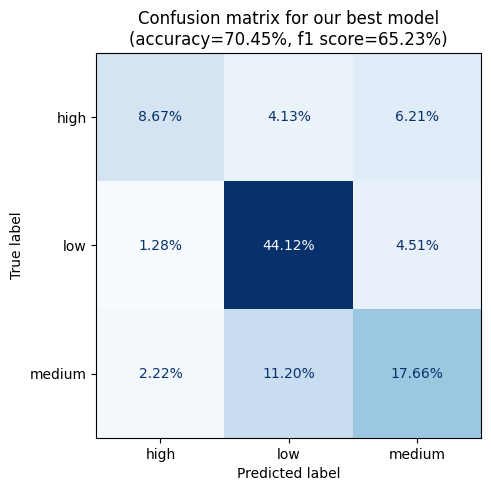

In [82]:
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(y_test, y_pred, normalize="all")
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(
    cmap="Blues", values_format='.2%', colorbar=False, include_values=True, ax=ax)
ax.set_title("Confusion matrix for our best model"+f"\n(accuracy={accuracy_score(y_test, y_pred):.2%}, f1 score={f1_score(y_test, y_pred, average='macro'):.2%})")
plt.show()

If the results can be considered satisfactory for a proof of concept, there are some errors that are more important than others. We see that the model is very good at predicting the `low` category but it struggles with the `high` category. This is not surprising as the `high` category is the smallest one and thus the model has less data to learn from. A larger dataset or a more balanced mean action score distribution would probably help the model to learn better.

Let's dive further into the more important errors. The biggest issue is for `low` action scores classified as `high`. In fact, this could drive us to invest in the company from an ESG perspective while the company is actually not doing well. Let's look at the documents that are classified as `high` but have a mean action score below 0.1 and see if we can find a pattern.

In [99]:
pb_indexes = [i for i,val in enumerate(np.logical_and(y_test=="low",y_pred=="high")) if val]
pd_df = df.iloc[X_test.iloc[pb_indexes].index]

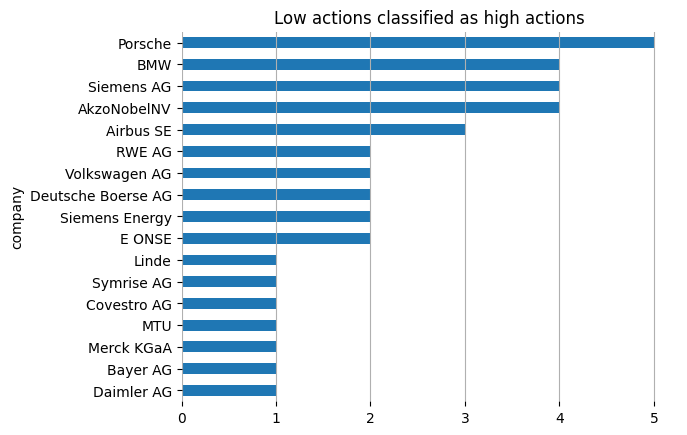

In [106]:
pd_df.company.value_counts().sort_values().plot(kind="barh")
plt.title("Low actions classified as high actions")
plt.box(False)
plt.grid(axis='x')
plt.savefig("DATA/figures/Missclassified.png")

plt.show()

In [110]:
pd_df[pd_df["company"]=="Porsche"].to_excel("Porsche_debug.xlsx")

We see that there are only very few documents that are classified as `high` but have a mean action score below 0.1. `Porsche` stood out as it has 5 of these misclassified documents. After reading the documents, we notice that all of them talk about electric cars. The classifier probably picked up on the word 'electric' and classified the document as `high` because it is a hot topic in the ESG space. The reason why the mean action score might be low is because the documents also talk about the fact that Porsche is not doing well in the electric car space (and had to call a lot of cars back for example). This is typically a grey area where good and systematic annotation of the documents would be needed to be able to classify them better. 

### 6.2. Errors clustering

The final step of our analysis is to look at the similarities between the documents that are misclassified to see if we can find a pattern. We will use the `KMeans` algorithm to cluster the documents based on their embeddings. We will then look at the clusters that contain the most misclassified documents and try to understand what went wrong.

In [123]:
from sklearn.cluster import KMeans

X, y = data_prep(pd_df, embed_col="embedding", verbose=True)
KMeans_model = KMeans(n_clusters=3, random_state=seed)
KMeans_model.fit(X)
pd_df["cluster"] = KMeans_model.labels_

print(pd_df["cluster"].value_counts())
# Let's look at the companies in each cluster to see if we can find a pattern
for i in range(3):
    print(f"Cluster {i} ------------------")
    print(pd_df[pd_df["cluster"]==i].company.value_counts().sort_values()[-10:])
    print("\n")

pd_df[pd_df["cluster"]==1].to_excel("DATA/Cars_cluster.xlsx")


>>> Preparing data for BOW model
X shape: (37, 384)
y shape: (37,)
cluster
2    15
0    12
1    10
Name: count, dtype: int64
Cluster 0 ------------------
company
Airbus SE        1
BMW              1
AkzoNobelNV      1
Symrise AG       1
Volkswagen AG    1
RWE AG           1
Bayer AG         1
Linde            1
Siemens AG       4
Name: count, dtype: int64


Cluster 1 ------------------
company
Volkswagen AG    1
MTU              1
Daimler AG       1
Airbus SE        1
BMW              2
Porsche          4
Name: count, dtype: int64


Cluster 2 ------------------
company
Merck KGaA            1
Airbus SE             1
Porsche               1
Covestro AG           1
BMW                   1
RWE AG                1
Siemens Energy        2
E ONSE                2
Deutsche Boerse AG    2
AkzoNobelNV           3
Name: count, dtype: int64




c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\AppData\Local\Temp\ipykernel_17672\4192040151.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df["cluster"] = KMeans_model.labels_


The `Cluster 1` seems to contain mostly car manufacturer company with the exception of Airbus. There could be an ambiguity linked to the engine or consumption. After exporting the missclassified documents, we see that 8 of them talk about electric cars and 2 about hydrogen fuel in aviation. Transitioning towards new energy sources is definitely a positive thing from an ESG perspective and should be encouraged. It therefore seems that these classifications are actually correct and capture inconsistencies in the annotation (cars and aviation are probably just assumed to be bad for the environment in the ESG BERT model used to annotate the text). Similar explorations could be done for the other clusters and for the other (less critical) missclassifications.

Thank you for reading this notebook. I hope you enjoyed it and that it gave you some insights into the potential of NLP for ESG analysis.

---
Mathieu Demarets (mathieu.demarets@edu.vlerick.com)